# Demand Forecasting using Tree-based Regression : Random Forest 

By Team Nugget - Crystal Liu, Daria Zhan, Mei Yang, Pallavi Sama, Sarah Gustafson

MSBA | UC Davis | 442-Advance Statistics | Final Project 

March 9th, 2018

<img src="Picture1.png",height=300, width=600>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Libraries-&amp;-Data" data-toc-modified-id="Importing-Libraries-&amp;-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Libraries &amp; Data</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Exploratory-Data-Analyses-&amp;-Visualization" data-toc-modified-id="Exploratory-Data-Analyses-&amp;-Visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analyses &amp; Visualization</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Model-Development" data-toc-modified-id="Model-Development-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Development</a></span></li></ul></div>

### Importing Libraries & Data

In [34]:
# Importing the required libraries
library(dplyr)
library(ggplot2)
library(randomForest)
library(party)
library(reshape2)

In [49]:
# To replicate the results
set.seed(1)

# Reading the datasets
train <- read.csv("../input/train.csv")
store <- read.csv("../input/store.csv")

# Merge to get the store info into datasets
train <- merge(train,store)

# Let's get a quick glimpse on the dataset
glimpse(train)
summary(train)

Observations: 1,017,209
Variables: 12
$ Store               <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ DayOfWeek           <int> 5, 6, 5, 3, 3, 7, 3, 1, 5, 1, 6, 3, 6, 4, 3, 4,...
$ Date                <fct> 2015-07-31, 2013-01-12, 2014-01-03, 2014-12-03,...
$ Sales               <int> 5263, 4952, 4190, 6454, 3310, 0, 3591, 4770, 38...
$ Customers           <int> 555, 646, 552, 695, 464, 0, 453, 542, 466, 480,...
$ Open                <int> 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ Promo               <int> 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,...
$ StateHoliday        <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ SchoolHoliday       <int> 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,...
$ StoreType           <fct> c, c, c, c, c, c, c, c, c, c, c, c, c, c, c, c,...
$ Assortment          <fct> a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a,...
$ CompetitionDistance <int> 1270, 1270, 1270, 1270, 1270, 1270, 1270, 1270,...


     Store          DayOfWeek             Date             Sales      
 Min.   :   1.0   Min.   :1.000   2013-01-02:   1115   Min.   :    0  
 1st Qu.: 280.0   1st Qu.:2.000   2013-01-03:   1115   1st Qu.: 3727  
 Median : 558.0   Median :4.000   2013-01-04:   1115   Median : 5744  
 Mean   : 558.4   Mean   :3.998   2013-01-05:   1115   Mean   : 5774  
 3rd Qu.: 838.0   3rd Qu.:6.000   2013-01-06:   1115   3rd Qu.: 7856  
 Max.   :1115.0   Max.   :7.000   2013-01-07:   1115   Max.   :41551  
                                  (Other)   :1010519                  
   Customers           Open            Promo        StateHoliday
 Min.   :   0.0   Min.   :0.0000   Min.   :0.0000   0:986159    
 1st Qu.: 405.0   1st Qu.:1.0000   1st Qu.:0.0000   a: 20260    
 Median : 609.0   Median :1.0000   Median :0.0000   b:  6690    
 Mean   : 633.1   Mean   :0.8301   Mean   :0.3815   c:  4100    
 3rd Qu.: 837.0   3rd Qu.:1.0000   3rd Qu.:1.0000               
 Max.   :7388.0   Max.   :1.0000   Max.   

### Data Cleaning

In [50]:
# There are some NAs in the competition distance column, so let us impute that with the median
train$CompetitionDistance[is.na(train$CompetitionDistance)] <- median(train$CompetitionDistance, na.rm=TRUE)
summary(train$CompetitionDistance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     20     710    2330    5422    6880   75860 

In [51]:
# Removing the stores that were closed
train <- train[which(train$Open == '1'),]

# Considering only the observations with sales > 0
train <- train[which(train$Sales > 0),]

# Extracting the elements of the date column
train$month <- as.integer(format(as.Date(train$Date), "%m"))
train$year <- as.integer(format(as.Date(train$Date), "%Y"))
train$day <- as.integer(format(as.Date(train$Date), "%d"))

# Converting the categorical integer data to factor 
train$Store <- as.factor(train$Store)
train$DayOfWeek <- as.factor(train$DayOfWeek)
train$Open <- as.factor(train$Open)
train$Promo <- as.factor(train$Promo)
train$StateHoliday <- as.factor(ifelse(train$StateHoliday == '0', 0, 1))
train$SchoolHoliday <- as.factor(train$SchoolHoliday)
train$month <- as.factor(train$month)
train$year <- as.factor(train$year)

### Exploratory Data Analyses & Visualization

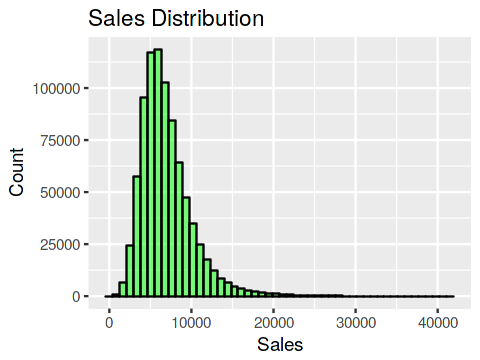

In [5]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of Sales
ggplot(data=train, aes(train$Sales)) + 
  geom_histogram(bins=50, col="black", fill="green", alpha = .5) + 
  labs(title="Sales Distribution") +
  labs(x="Sales", y="Count")

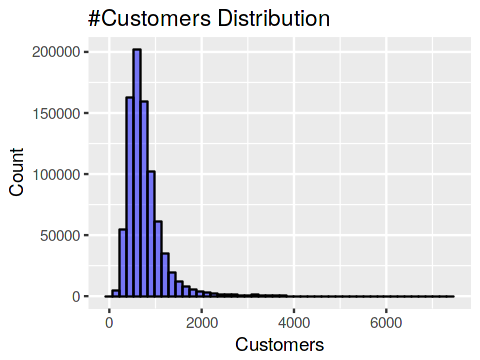

In [6]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of Customers
ggplot(data=train, aes(train$Customers)) + 
  geom_histogram(bins=50, col="black", fill="blue", alpha = .5) + 
  labs(title="#Customers Distribution") +
  labs(x="Customers", y="Count")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


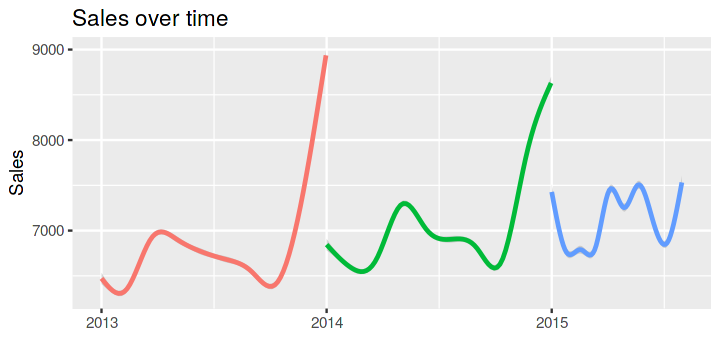

In [7]:
options(repr.plot.width=6, repr.plot.height=3)
# Line chart to show sales over time
ggplot(train, aes(x = as.Date(Date), y = Sales, color = factor(year))) + 
  geom_smooth() +
  labs(title="Sales over time") +
  labs(x="", y="Sales") +
  guides(color=FALSE)

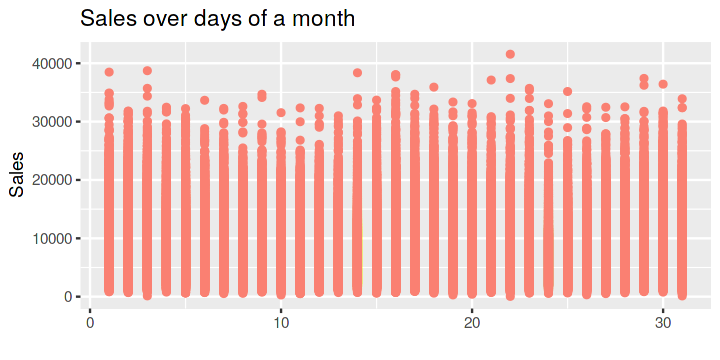

In [8]:
options(repr.plot.width=6, repr.plot.height=3)
# Sales over days of a month
ggplot(train, aes(x = day, y = Sales)) + 
  geom_point(col="salmon") +
  labs(title="Sales over days of a month") +
  labs(x="", y="Sales")

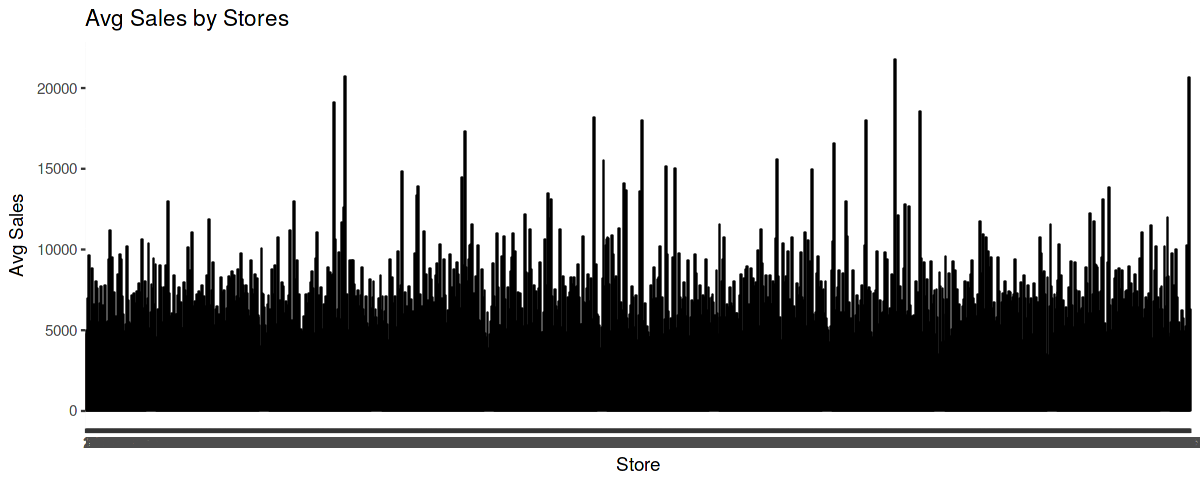

In [9]:
temp <- train %>%
  group_by(Store) %>%
  summarise(avgSales = mean(Sales)) %>%
  as.data.frame
options(repr.plot.width=10, repr.plot.height=4)
# Distribution of Sales by Store ID
ggplot(data=temp, aes(x=temp$Store, y=temp$avgSales)) + 
  geom_bar(stat="identity",col="black", fill="red", alpha = .3) + 
  labs(title="Avg Sales by Stores") +
  labs(x="Store", y="Avg Sales")

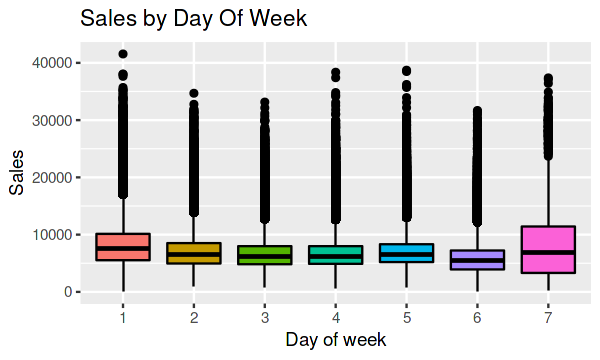

In [10]:
options(repr.plot.width=5, repr.plot.height=3)
# Distribution by day of the week
ggplot(train, aes(x = factor(DayOfWeek), y = Sales, fill=DayOfWeek)) +
  geom_boxplot(color = "black") +
  labs(title="Sales by Day Of Week") +
  labs(x="Day of week", y="Sales") +
  guides(fill=FALSE)

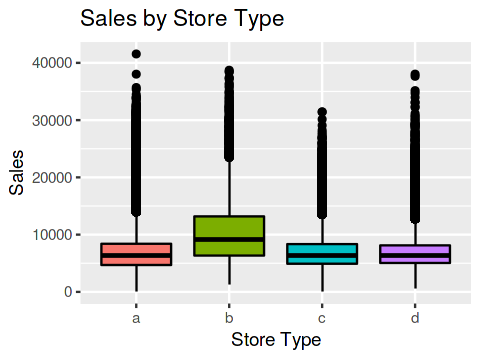

In [11]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution by Store type
ggplot(train, aes(x = factor(StoreType), y = Sales, fill=StoreType)) +
  geom_boxplot(color = "black") +
  labs(title="Sales by Store Type") +
  labs(x="Store Type", y="Sales") +
  guides(fill=FALSE)

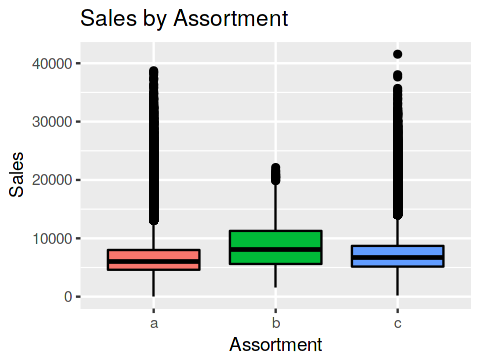

In [12]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution by Assortment
ggplot(train, aes(x = factor(Assortment), y = Sales, fill=Assortment)) +
  geom_boxplot(color = "black") +
  labs(title="Sales by Assortment") +
  labs(x="Assortment", y="Sales") +
  guides(fill=FALSE)

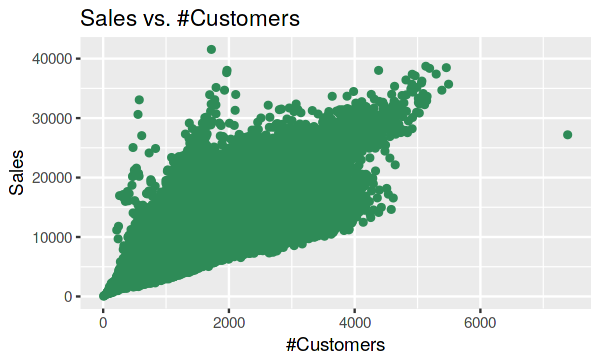

In [13]:
options(repr.plot.width=5, repr.plot.height=3)
# Sales vs. Customers
ggplot(train, aes(x = Customers, y = Sales)) + 
  geom_point(col="seagreen") +
  labs(title="Sales vs. #Customers") +
  labs(x="#Customers", y="Sales")

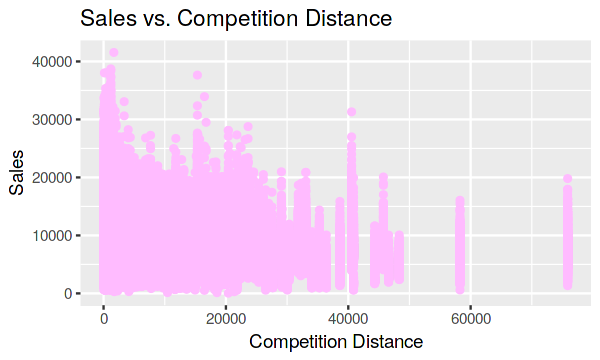

In [14]:
options(repr.plot.width=5, repr.plot.height=3)
# Sales vs. Competition Distance
ggplot(train, aes(x = CompetitionDistance, y = Sales)) + 
  geom_point(col="plum1") +
  labs(title="Sales vs. Competition Distance") +
  labs(x="Competition Distance", y="Sales")

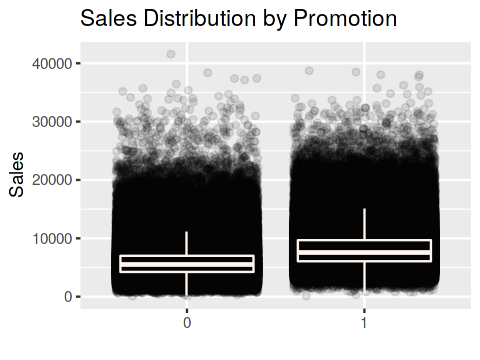

In [15]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of sales by Promotion
ggplot(train, aes(x = factor(Promo), y = Sales)) + 
  geom_jitter(alpha = 0.1) +
  geom_boxplot(color = "seashell", outlier.colour = NA, fill = NA) +
  labs(title="Sales Distribution by Promotion") +
  labs(x="", y="Sales")

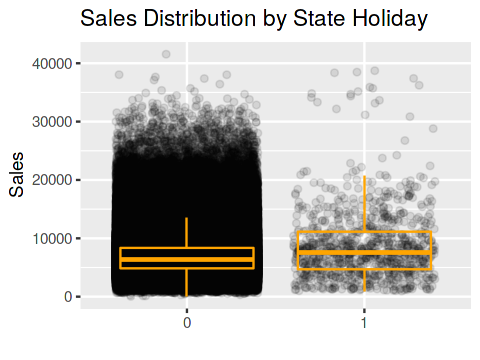

In [16]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of sales by State Holiday
ggplot(train, aes(x = factor(StateHoliday), y = Sales)) + 
  geom_jitter(alpha = 0.1) +
  geom_boxplot(color = "orange", outlier.colour = NA, fill = NA) +
  labs(title="Sales Distribution by State Holiday") +
  labs(x="", y="Sales")

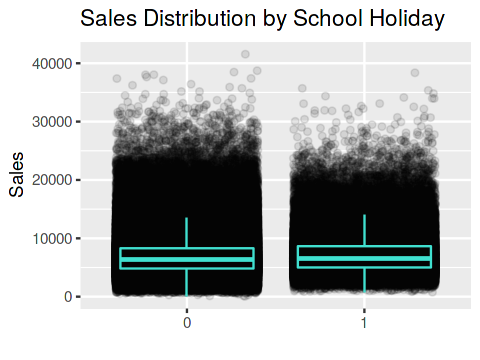

In [17]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of sales by School Holiday
ggplot(train, aes(x = factor(SchoolHoliday), y = Sales)) + 
  geom_jitter(alpha = 0.1) +
  geom_boxplot(color = "turquoise", outlier.colour = NA, fill = NA) +
  labs(title="Sales Distribution by School Holiday") +
  labs(x="", y="Sales")

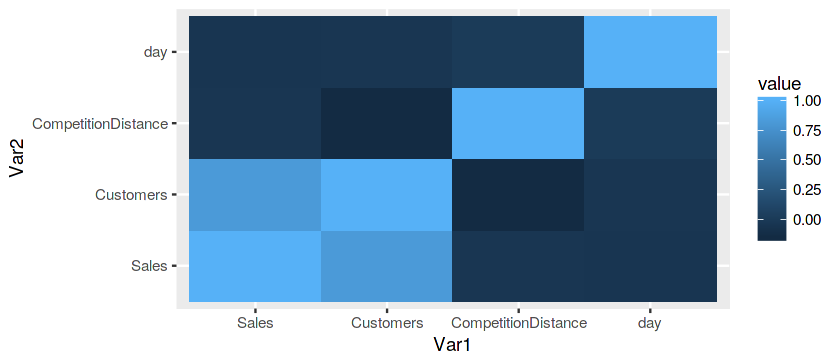

In [18]:
options(repr.plot.width=7, repr.plot.height=3)
# Creating a correlation heat map for the numeric vars
nums <- sapply(train, is.numeric)
cormat <- round(cor(train[,nums]),2)
melted_cormat <- melt(cormat)
ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()

In [52]:
# Removing the date column as required elements have been extracted
train <- train[,-c(3)]

### Feature Engineering

In [53]:
# Even though sales will vary from store to store, let's create average sales per store per mth as another variable
# Also, we can't use so many levels in a categorical variable
storeAvgSales <- train %>%
  group_by(Store, month) %>%
  summarise(store_avg_salespm = mean(Sales))
# No. of customers itself can be a response variable to predict, so will use avg cust per mth per store
storeAvgCust <- train %>%
  group_by(Store, month) %>%
  summarise(store_avg_custpm = mean(Customers))

# Merging them back to the main dataset
train <- merge(train, storeAvgSales, by=c("Store","month"))
train <- merge(train, storeAvgCust, by=c("Store","month"))

head(train)

Store,month,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,year,day,store_avg_salespm,store_avg_custpm
1,1,6,4546,561,1,0,0,0,c,a,1270,2014,25,4703.167,575.359
1,1,6,5173,660,1,0,0,1,c,a,1270,2014,4,4703.167,575.359
1,1,3,3789,491,1,0,0,0,c,a,1270,2014,29,4703.167,575.359
1,1,3,4008,530,1,0,0,0,c,a,1270,2013,16,4703.167,575.359
1,1,3,4310,537,1,1,0,0,c,a,1270,2015,28,4703.167,575.359
1,1,5,4906,589,1,0,0,0,c,a,1270,2014,31,4703.167,575.359


In [54]:
# Sampling a small subset to train due to resource limitations
n = nrow(train)
trainIndex = sample(1:n, size = 50000, replace=FALSE)
train = train[trainIndex ,]
summary(train) 

     Store           month       DayOfWeek     Sales         Customers     
 863    :   70   1      : 5206   1:7968    Min.   :  582   Min.   :  61.0  
 1113   :   69   7      : 5152   2:8525    1st Qu.: 4868   1st Qu.: 521.0  
 578    :   68   3      : 5095   3:8441    Median : 6386   Median : 678.0  
 262    :   67   6      : 4883   4:8000    Mean   : 6971   Mean   : 766.7  
 227    :   66   4      : 4759   5:8213    3rd Qu.: 8385   3rd Qu.: 897.0  
 453    :   66   5      : 4745   6:8628    Max.   :34904   Max.   :5014.0  
 (Other):49594   (Other):20160   7: 225                                    
 Open      Promo     StateHoliday SchoolHoliday StoreType Assortment
 1:50000   0:27710   0:49941      0:40224       a:27301   a:26305   
           1:22290   1:   59      1: 9776       b:  924   b:  484   
                                                c: 6694   c:23211   
                                                d:15081             
                                               

In [55]:
# Let's split the dataset into train and test - 70-30
n = nrow(train)
trainIndex = sample(1:n, size = round(0.7*n), replace=FALSE)
train = train[trainIndex ,]
test = train[-trainIndex ,]

In [56]:
# Extracting the candidate variables to build the model
feature.names <- names(train)[c(2:3,7:12,14:16)]
feature.names

[1] "month"               "DayOfWeek"           "Promo"              
 [4] "StateHoliday"        "SchoolHoliday"       "StoreType"          
 [7] "Assortment"          "CompetitionDistance" "day"                
[10] "store_avg_salespm"   "store_avg_custpm"

In [57]:
# Building the Random Forest model
model_rf <- randomForest(train[,feature.names], 
                         train$Sales,
                         mtry=4,
                         ntree=20,
                         do.trace=TRUE)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
   1 | 2.667e+06    27.46 |
   2 | 2.421e+06    24.93 |
   3 | 2.327e+06    23.96 |
   4 | 2.243e+06    23.10 |
   5 | 2.134e+06    21.98 |
   6 | 2.031e+06    20.92 |
   7 | 1.934e+06    19.92 |
   8 | 1.849e+06    19.05 |
   9 | 1.774e+06    18.27 |
  10 | 1.729e+06    17.80 |
  11 | 1.667e+06    17.17 |
  12 | 1.623e+06    16.72 |
  13 | 1.592e+06    16.39 |
  14 | 1.566e+06    16.12 |
  15 | 1.533e+06    15.79 |
  16 | 1.515e+06    15.60 |
  17 | 1.497e+06    15.42 |
  18 | 1.482e+06    15.27 |
  19 | 1.469e+06    15.13 |
  20 | 1.453e+06    14.96 |


[1] "model stats:"



Call:
 randomForest(x = train[, feature.names], y = train$Sales, ntree = 20,      mtry = 4, do.trace = TRUE) 
               Type of random forest: regression
                     Number of trees: 20
No. of variables tried at each split: 4

          Mean of squared residuals: 1452597
                    % Var explained: 85.04

[1] "Training RMSE:"
[1] 1351.058


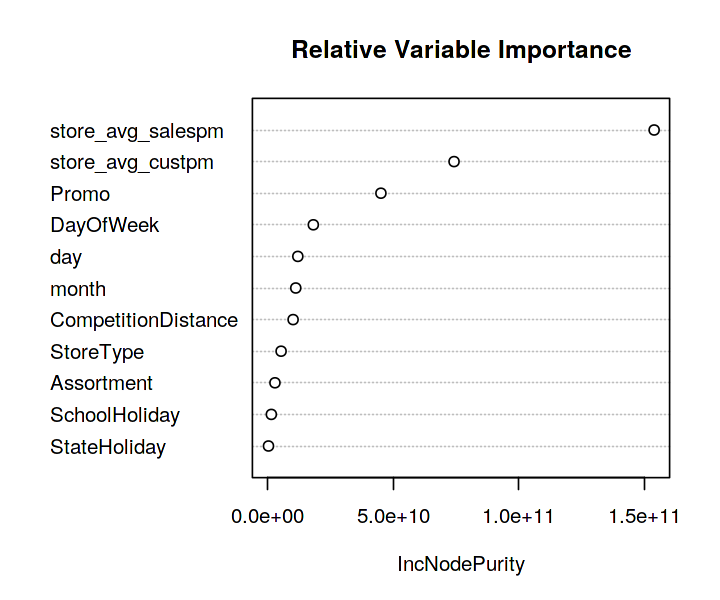

[1] "Training RMSE:"
[1] 578.2262
[1] "Training MAPE:"
[1] 6.039126


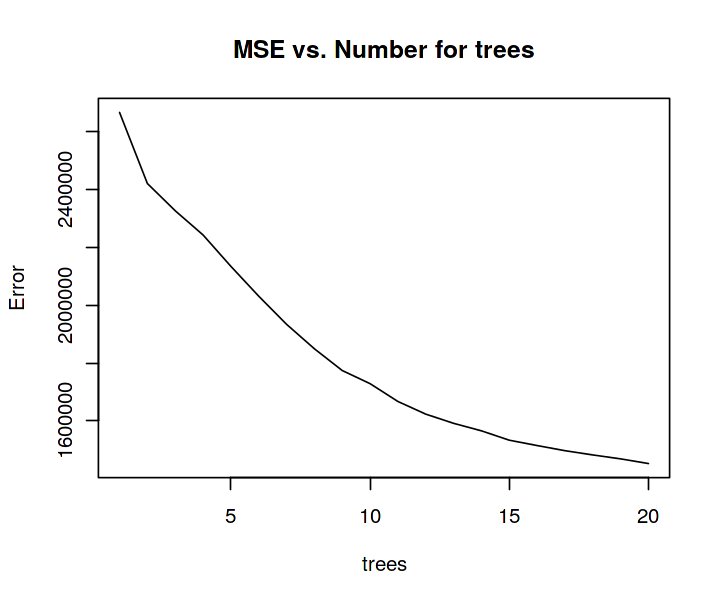

In [58]:
# Assessing the model performance
print("model stats:");model_rf
print("Training RMSE:");print(sqrt(mean(model_rf$mse)))

# Plotting the variable importance
options(repr.plot.width=6, repr.plot.height=5)
varImpPlot(model_rf, main="Relative Variable Importance")

# Plotting MSE wrt to the incremental trees
plot(model_rf, main="MSE vs. Number for trees")

# Calculating training prediction accuracy
pred_tr <- predict(model_rf, train[,feature.names])
print("Training RMSE:");print(sqrt(mean((train$Sales-pred_tr)^2)))
print("Training MAPE:");print(mean(abs((train$Sales-pred_tr)/train$Sales) * 100))

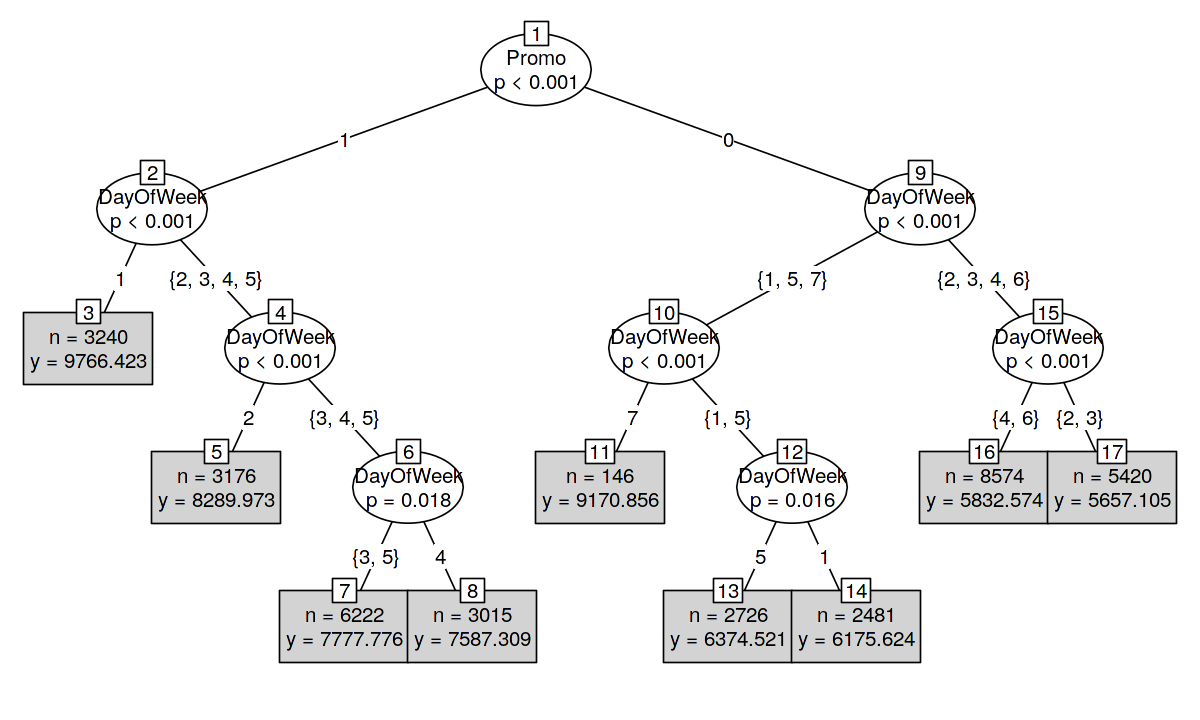

In [28]:
options(repr.plot.width=10, repr.plot.height=6)
# Plotting a simple conditional tree to demonstrate the Random Forest internal splitting
demoT <- ctree(Sales ~ Promo + DayOfWeek, data=train)                                    
plot(demoT, type="simple")

### Model Development

In [59]:
# Prediction using Test data
summary(test)
pred <- predict(model_rf, test[,feature.names])
print("Test RMSE:");print(sqrt(mean((test$Sales-pred)^2)))
print("Test MAPE:");print(mean(abs((test$Sales-pred)/test$Sales) * 100))

     Store           month      DayOfWeek     Sales         Customers     
 530    :   22   1      :1123   1:1693    Min.   :  708   Min.   : 103.0  
 585    :   21   7      :1104   2:1820    1st Qu.: 4895   1st Qu.: 524.0  
 783    :   20   3      :1074   3:1801    Median : 6419   Median : 683.0  
 453    :   19   6      :1007   4:1672    Mean   : 7011   Mean   : 770.4  
 578    :   19   2      : 995   5:1743    3rd Qu.: 8431   3rd Qu.: 904.0  
 965    :   19   4      : 970   6:1769    Max.   :31842   Max.   :4175.0  
 (Other):10425   (Other):4272   7:  47                                    
 Open      Promo    StateHoliday SchoolHoliday StoreType Assortment
 1:10545   0:5820   0:10532      0:8479        a:5766    a:5540    
           1:4725   1:   13      1:2066        b: 196    b:  95    
                                               c:1411    c:4910    
                                               d:3172              
                                                            

[1] "Test RMSE:"
[1] 582.4283
[1] "Test MAPE:"
[1] 6.076937
